# RAIL Onboarding 02: The Visual Simulator

Previous Tutorial: [RAIL Onboarding 01: Navigation in a Known Grid](./RAIL-onboarding-01-known-space-navigation.ipynb)

**Goal**: to run our Unity visual simulator corresponding to a procedurally generated map.

### Imports and Setup

These imports are effectively the same as in the previous tutoial, and for clarity we will use the same arguments.

In [1]:
# Imports & Setup (same as the previous tutorial)

import common
import environments
import lsp
import matplotlib.pyplot as plt
import numpy as np
import os
import math
import gridmap
import sys

print("Python Version and System Information")
print(sys.version)

# Set the arguments (usually done via the command line)
args = lambda: None
args.current_seed = 2005
args.map_type = 'maze'
args.unity_path = '/unity/rail_sim.x86_64'
args.save_dir = './'

# Robot Arguments
args.step_size = 1.8
args.num_primitives = 32
args.laser_scanner_num_points = 1024
args.field_of_view_deg = 360

known_map, map_data, pose, goal = environments.generate.map_and_poses(args)

Python Version and System Information
3.10.12 (main, May 27 2025, 17:12:29) [GCC 11.4.0]


## Spinning Up the Visual Simulator

Our simulation environment is built in the Unity game engine and called in the background by Python so that we can communicate with it over TCP. From Python, we instantiate an object via a helper class `WorldBuildingUnityBridge` from `environments.simulated` and using a python `with` statement, which requires a path to the Unity environment (set to `/unity/rail-sim.x86_64` within the Docker container running this tutorial).

Let's see what the simulator looks like when we simply load it and ask for an image:

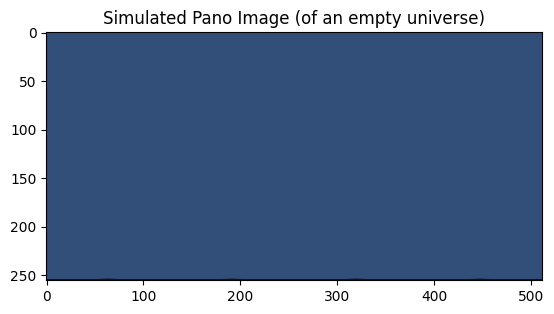

In [9]:
## Create the Unity Bridge, which talks to the visual simulator
builder = environments.simulated.WorldBuildingUnityBridge

# Open the simulator and generate an image
with builder(args.unity_path) as unity_bridge:
    # Move the robot and generate a simulated image
    unity_bridge.move_object_to_pose("robot", common.Pose(0, 0))
    pano_image = unity_bridge.get_image("robot/pano_camera")
    
    # Plotting
    plt.imshow(pano_image)
    plt.title("Simulated Pano Image (of an empty universe)")
    plt.show()

You should see... basically nothing. The output is just a blue rectangle. That's because without any instructions the simulated environment is a blank canvas. **We need to add stuff to the scene!**

For this purpose, we provide helper classes—also in `environments.simulated`—that communicate information about our generated map to the visual simulator. We instantiate one of these `World` subclass objects, specifically an `OccupancyGridWorld` meant to build a visual simulator instance from an occupancy grid, and then call `unity_bridge.make_world(world)` to populate the simulator. We move the simulated robo into place and then collect the images we want.

yay!


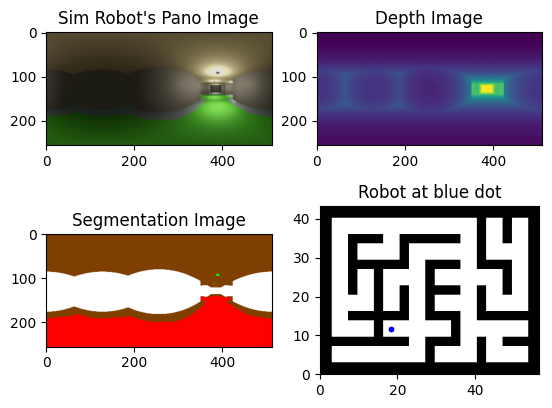

In [12]:
## Create the Unity Bridge, which talks to the visual simulator
builder = environments.simulated.WorldBuildingUnityBridge

# A helper object for passing map data to the simulator
world = environments.simulated.OccupancyGridWorld(
    known_map, map_data,
    num_breadcrumb_elements=args.num_breadcrumb_elements,
    min_breadcrumb_signed_distance=4.0 * args.base_resolution)

# Open the simulator and generate an image
with builder(args.unity_path) as unity_bridge:
    # Populate the simulated world with objects via the 'world'
    # helper object.
    unity_bridge.make_world(world)
    
    # Move the robot into place
    unity_bridge.move_object_to_pose("robot", args.base_resolution * pose)
    
    # Generate a simulated images
    pano_image = unity_bridge.get_image("robot/pano_camera")
    pano_depth = environments.utils.convert.depths_from_depth_image(
        unity_bridge.get_image("robot/pano_depth_camera"))
    pano_seg = unity_bridge.get_image("robot/pano_segmentation_camera")
    
    # Plotting
    ax = plt.subplot(221)
    plt.imshow(pano_image)
    plt.title("Sim Robot's Pano Image")
    
    raw_depth_image = unity_bridge.get_image("robot/pano_depth_camera")
    ax = plt.subplot(222)
    plt.imshow(pano_depth)
    plt.title("Depth Image")
    
    segmentation_image = unity_bridge.get_image("robot/pano_segmentation_camera")
    ax = plt.subplot(223)
    plt.imshow(pano_seg)
    plt.title("Segmentation Image")
    
    ax = plt.subplot(224)
    lsp.utils.plotting.plot_navigation_data(
        ax, known_map, map_data=map_data, 
        robot_pose=args.base_resolution*pose)
    plt.title("Robot at blue dot")

None
print('yay!')

Now we can see much more! In addition to plotting an RGB "camera" image, we can also generate depth and semantic segmentation, both useful for downstream applications. All images are *equirectangular projections*, and so contain full panoramic and "up-down" information at the location of the robot. Often, we crop off the top and bottom, keeping on the middle vertical "half" of the image, since the ceiling and floor are not so often useful for our purposes.

## Generating Observations During Navigation

With our newfound capabilities, we can augment the code from the previous tutorial to also include generating images. Thus the simulated robot will move from start to goal and generate images as it does.

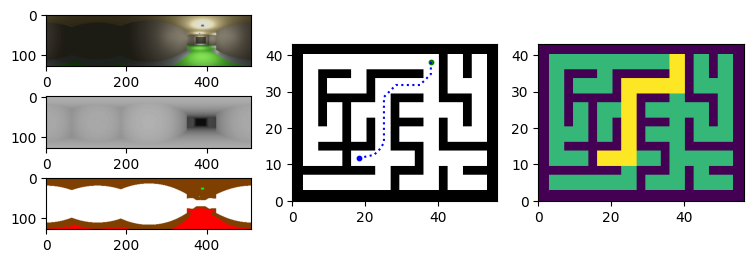

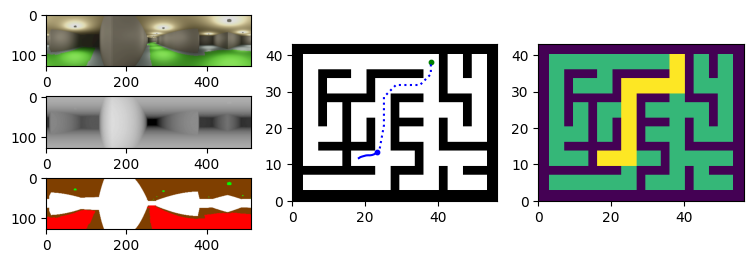

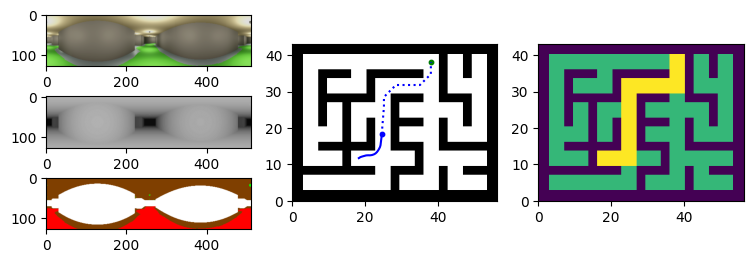

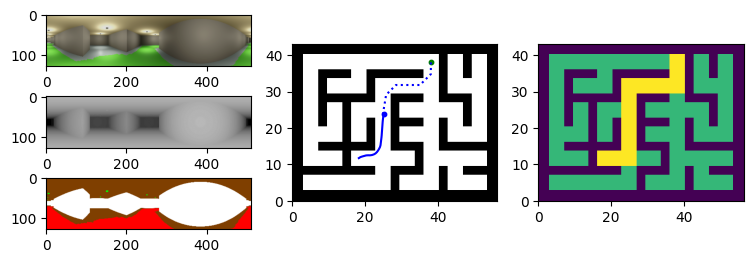

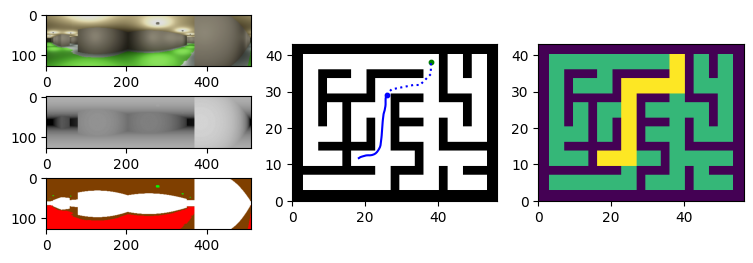

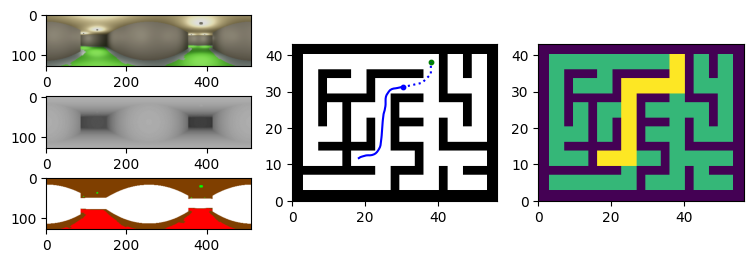

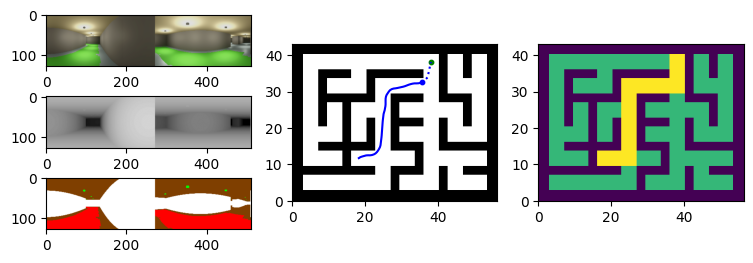

In [13]:
## Now run the code in the known grid.

# Compute the inflation radius (in grid units) and apply
inflation_radius = args.inflation_radius_m / args.base_resolution
inflated_known_grid = gridmap.utils.inflate_grid(
    known_map, inflation_radius=inflation_radius)

robot = lsp.robot.Turtlebot_Robot(
    pose,
    primitive_length=args.step_size,
    num_primitives=args.num_primitives,
    map_data=map_data)

counter = 0

# Planning loop
with builder(args.unity_path) as unity_bridge:
    # Populate the simulated world with objects (once)
    unity_bridge.make_world(world)

    # Iteratively move the robot and replan
    while (math.fabs(robot.pose.x - goal.x) >= 3 * args.step_size
            or math.fabs(robot.pose.y - goal.y) >= 3 * args.step_size):
        # Compute the cost grid for the current robot pose
        cost_grid, get_path = gridmap.planning.compute_cost_grid_from_position(
            inflated_known_grid, [goal.x, goal.y], use_soft_cost=True)
        did_plan, path = get_path([robot.pose.x, robot.pose.y],
                              do_sparsify=True, do_flip=True)

        # Plotting
        if counter % 10 == 0:
            plt.ion()
            plt.figure(1, figsize=(9, 3))
            plt.clf()
    
            # Update the simulation environment
            unity_bridge.move_object_to_pose("robot", robot.pose_m)
            pano_image = unity_bridge.get_image("robot/pano_camera")
            pano_depth = environments.utils.convert.depths_from_depth_image(
                unity_bridge.get_image("robot/pano_depth_camera"))
            pano_seg = unity_bridge.get_image("robot/pano_segmentation_camera")

            # Plot the images (cropping the top and bottom)
            sh = pano_image.shape
            ax = plt.subplot(331)
            plt.imshow(pano_image[sh[0]//4:3*sh[0]//4])
            ax = plt.subplot(334)
            plt.imshow(pano_depth[sh[0]//4:3*sh[0]//4], 
                       cmap='gray_r', vmin=0, vmax=64)
            ax = plt.subplot(337)
            plt.imshow(pano_seg[sh[0]//4:3*sh[0]//4])
            
            ax = plt.subplot(132)
            lsp.utils.plotting.plot_navigation_data(
                ax, known_map, map_data=map_data, 
                robot_pose=robot.pose_m, 
                goal_pose=args.base_resolution*goal,
            planned_path=path,
            robot_poses=robot.all_poses)
            
            if 'semantic_grid' in map_data.keys():
                ax = plt.subplot(133)
                lsp.utils.plotting.plot_grid_to_scale(ax, map_data['semantic_grid'], map_data)
            
            plt.show()

        # Get the motion primitives, pick one (min cost), and execute it
        motion_primitives = robot.get_motion_primitives()
        costs, _ = lsp.primitive.get_motion_primitive_costs(
            inflated_known_grid, cost_grid, robot.pose, path,
            motion_primitives, do_use_path=True)
        robot.move(motion_primitives, np.argmin(costs))
        
        # Counter
        counter += 1

None